In [ ]:
!pip uninstall numpy -y

Found existing installation: numpy 1.25.0
Uninstalling numpy-1.25.0:
  Successfully uninstalled numpy-1.25.0


In [1]:
!pip install numpy==1.25.0

In [2]:
!pip install --upgrade gensim


  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#To run this code just change the path name as mentioned below after downloading the required files
#I have uploaded those things on my drive and accessing them from there
english_embedding_path = '/content/cc.en.300.vec.gz'
hindi_embedding_path = '/content/cc.hi.300.vec.gz'




In [5]:
from gensim.models import KeyedVectors

en_model = KeyedVectors.load_word2vec_format(english_embedding_path, binary=False)
hi_model = KeyedVectors.load_word2vec_format(hindi_embedding_path, binary=False)

In [6]:
# Extracting top 100,000
top_k = 100000

en_top_words = en_model.index_to_key[:top_k]
hi_top_words = hi_model.index_to_key[:top_k]

# Build filtered dictionaries
en_filtered = {word: en_model[word] for word in en_top_words}
hi_filtered = {word: hi_model[word] for word in hi_top_words}


In [7]:
print(f"English vocab size: {len(en_filtered)}")
print(f"Hindi vocab size: {len(hi_filtered)}")
print(f"Sample English words: {list(en_filtered.keys())[:5]}")
print(f"Sample Hindi words: {list(hi_filtered.keys())[:5]}")

English vocab size: 100000
Hindi vocab size: 100000
Sample English words: [',', 'the', '.', 'and', 'to']
Sample Hindi words: ['के', '।', 'है', ',', 'में']


IMPORTING NECCESITIES


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from scipy.linalg import orthogonal_procrustes
import urllib.request
import os
import gzip
import io
import tarfile
import time


In [9]:
#Downloading and process the MUSE bilingual dictionary

def download_muse_dictionary(src_lang='en', tgt_lang='hi'):
    print(f"Downloading {src_lang}-{tgt_lang} dictionary...")
    base_url = "https://dl.fbaipublicfiles.com/arrival/dictionaries/"
    src_file = f"{src_lang}-{tgt_lang}.0-5000.txt"
    tgt_file = f"{tgt_lang}-{src_lang}.0-5000.txt"

    os.makedirs('dictionaries', exist_ok=True)
    #Downloading source to target
    urllib.request.urlretrieve(base_url + src_file, os.path.join('dictionaries', src_file))
    #Downloading target to source
    urllib.request.urlretrieve(base_url + tgt_file, os.path.join('dictionaries', tgt_file))
    print("Dictionary files downloaded successfully!")
    return os.path.join('dictionaries', src_file), os.path.join('dictionaries', tgt_file)

LOADING THE DICTIONARY

In [10]:

#Processing the dictionary files to create train and test sets


def load_dictionary(dict_path, src_vocab, tgt_vocab):
    word_pairs = []
    with open(dict_path, 'r', encoding='utf-8') as f:
        for line in f:
            src_word, tgt_word = line.strip().split()
            if src_word in src_vocab and tgt_word in tgt_vocab:
                word_pairs.append((src_word, tgt_word))
    return word_pairs


ALIGNMENT


    Learn a linear mapping between source and target embeddings using Procrustes analysis.
    
    Args:
        src_embs: Dictionary of source word embeddings
        tgt_embs: Dictionary of target word embeddings
        bilingual_dict: List of (source_word, target_word) pairs
        
    Returns:
        W: The learned mapping matrix


In [11]:
#Implementing the Procrustes alignment method


def learn_procrustes_alignment(src_embs, tgt_embs, bilingual_dict):
    print("Learning Procrustes alignment...")
    src_words = [pair[0] for pair in bilingual_dict]
    X = np.vstack([src_embs[word] for word in src_words])
    #Extract matrix of target word vectors
    tgt_words = [pair[1] for pair in bilingual_dict]
    Y = np.vstack([tgt_embs[word] for word in tgt_words])
    #Computing the optimal rotation matrix using Procrustes analysis
    #W will be an orthogonal matrix that maps X to Y
    W, _ = orthogonal_procrustes(X, Y)
    print(f"Mapping matrix shape: {W.shape}")
    return W


PRECISION@1 AND PRECISION@5


    Compute precision@k for word translation.
    
    Args:
        src_embs: Dictionary of source word embeddings
        tgt_embs: Dictionary of target word embeddings
        test_dict: List of (source_word, target_word) pairs for testing
        mapping_matrix: The learned mapping matrix
        k: The k in precision@k
        
    Returns:
        p_at_k: Precision@k score
        translations: Dictionary mapping source words to predicted translations


In [12]:
#Evaluateing translation accuracy


def compute_precision_at_k(src_embs, tgt_embs, test_dict, mapping_matrix, k=5):

    correct = 0
    translations = {}
    tgt_matrix = np.vstack([tgt_embs[word] for word in tgt_embs])
    tgt_words = list(tgt_embs.keys())

    print(f"Evaluating translation accuracy for {len(test_dict)} word pairs...")

    for i, (src_word, true_tgt_word) in enumerate(test_dict):
        if i % 500 == 0:
            print(f"Processed {i}/{len(test_dict)} word pairs...")

        src_vec = src_embs[src_word]  #Get source word embedding and map it to target space
        mapped_vec = np.dot(src_vec, mapping_matrix)
        similarities = cosine_similarity(mapped_vec.reshape(1, -1), tgt_matrix)[0] #Compute cosine similarities with all target words
        top_k_indices = similarities.argsort()[-k:][::-1]      #Get top-k most similar target words
        top_k_words = [tgt_words[idx] for idx in top_k_indices]
        translations[src_word] = top_k_words #Store translations
        if true_tgt_word in top_k_words: #Check if true translation is in top-k
            correct += 1

    p_at_k = correct / len(test_dict)
    print(f"Precision@{k}: {p_at_k:.4f}")
    return p_at_k, translations

ABLATION STUDY



    Conduct ablation study to assess impact of bilingual lexicon size.
    
    Args:
        src_embs: Dictionary of source word embeddings
        tgt_embs: Dictionary of target word embeddings
        train_dict: List of (source_word, target_word) pairs for training
        test_dict: List of (source_word, target_word) pairs for testing
        dict_sizes: List of dictionary sizes to test
        
    Returns:
        results: Dictionary with dictionary sizes as keys and precision scores as values

In [13]:
#Conducting ablation study with different dictionary sizes


def ablation_study(src_embs, tgt_embs, train_dict, test_dict, dict_sizes=[1000, 3000, 5000, 10000, 20000]):

    results = {'p@1': [], 'p@5': []}
    for size in dict_sizes:
        if size > len(train_dict):
            print(f"Warning: Requested dictionary size {size} exceeds available pairs {len(train_dict)}")
            size = len(train_dict)

        print(f"\nTesting with dictionary size: {size}")
        subset_dict = train_dict[:size]
        W = learn_procrustes_alignment(src_embs, tgt_embs, subset_dict)#Learn mapping with current dictionary size
        p_at_1, _ = compute_precision_at_k(src_embs, tgt_embs, test_dict, W, k=1)#Evaluate precision@1
        results['p@1'].append(p_at_1)
        p_at_5, translations = compute_precision_at_k(src_embs, tgt_embs, test_dict, W, k=5)#Evaluate precision@5
        results['p@5'].append(p_at_5)

    return results


COSINE SIMILARITY


    Analyze cosine similarities between word pairs after alignment.
    
    Args:
        src_embs: Dictionary of source word embeddings
        tgt_embs: Dictionary of target word embeddings
        test_dict: List of (source_word, target_word) pairs for testing
        mapping_matrix: The learned mapping matrix
        
    Returns:
        similarities: List of cosine similarities between aligned word pairs
  

In [14]:
#Analyzing cosine similarities between word pairs


def analyze_cosine_similarities(src_embs, tgt_embs, test_dict, mapping_matrix):

    similarities = []
    print("Analyzing cosine similarities...")
    for src_word, tgt_word in test_dict:
        src_vec = src_embs[src_word]#Get source word embedding and map it to target space
        mapped_vec = np.dot(src_vec, mapping_matrix)
        tgt_vec = tgt_embs[tgt_word] #Get target word embedding
        sim = cosine_similarity(mapped_vec.reshape(1, -1), tgt_vec.reshape(1, -1))[0][0]#Compute cosine similarity
        similarities.append((src_word, tgt_word, sim))

    return similarities

VISUALIZATION


    Plot the results of the ablation study.
    
    Args:
        results: Dictionary with dictionary sizes as keys and precision scores as values
        dict_sizes: List of dictionary sizes tested


In [15]:
#Visualizing results


def plot_ablation_results(results, dict_sizes):
    plt.figure(figsize=(10, 6))
    plt.plot(dict_sizes, results['p@1'], marker='o', label='Precision@1')
    plt.plot(dict_sizes, results['p@5'], marker='s', label='Precision@5')
    plt.xlabel('Bilingual Dictionary Size')
    plt.ylabel('Precision')
    plt.title('Impact of Bilingual Dictionary Size on Translation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('ablation_results.png')
    plt.show()


#EXTRA
I TRIED OPTIONAL AND WAS NOT ABLE TO RUN DUE TO COMPUTATIONAL CONSTRAINTS


BELOW IS THE CODE

In [ ]:
#Implementing CSLS for improved nearest neighbor retrieval
def get_nn_avg_dist(emb, query, knn):

    bs = 1024
    all_distances = []


    for i in range(0, query.shape[0], bs):# Compute distances for each batch to avoid memory issues
        batch = query[i:i + bs]
        distances = cdist(batch, emb, metric='cosine')
        distances = np.sort(distances, axis=1)[:, :knn]
        all_distances.append(distances)

    all_distances = np.vstack(all_distances)
    return all_distances.mean(axis=1)

def csls_retrieval(x_src, y_tgt, mapping_matrix, k=10):

    # Map source embeddings to target space
    x_mapped = np.dot(x_src, mapping_matrix)

    # Compute nearest neighbors
    src_avg_dist = get_nn_avg_dist(y_tgt, x_mapped, k)
    tgt_avg_dist = get_nn_avg_dist(x_mapped, y_tgt, k)

    # Compute CSLS scores
    cosine_sim = cosine_similarity(x_mapped, y_tgt)
    scores = 2 * cosine_sim

    # Subtract average distances
    scores -= np.tile(src_avg_dist[:, np.newaxis], (1, y_tgt.shape[0]))
    scores -= np.tile(tgt_avg_dist, (x_src.shape[0], 1))

    return scores

# Implement adversarial training for unsupervised word alignment
# (Note: This is a simplified version of the full adversarial approach in the MUSE paper)
def unsupervised_alignment(src_embs, tgt_embs, num_iterations=5):

    # Convert dictionaries to matrices
    src_words = list(src_embs.keys())
    tgt_words = list(tgt_embs.keys())

    X = np.vstack([src_embs[word] for word in src_words])
    Y = np.vstack([tgt_embs[word] for word in tgt_words])

    # Initialize with identity matrix
    W = np.eye(X.shape[1])

    for iteration in range(num_iterations):
        print(f"Iteration {iteration+1}/{num_iterations}")

        # Step 1: Map source embeddings to target space
        X_mapped = np.dot(X, W)

        # Step 2: Build synthetic dictionary using CSLS
        csls_scores = csls_retrieval(X, Y, W)
        src_indices = np.arange(len(src_words))
        tgt_indices = np.argmax(csls_scores, axis=1)

        # Step 3: Build synthetic dictionary
        synthetic_dict = [(src_words[i], tgt_words[j]) for i, j in zip(src_indices, tgt_indices)]

        # Step 4: Refine mapping with Procrustes analysis using synthetic dictionary
        W = learn_procrustes_alignment(src_embs, tgt_embs, synthetic_dict)

    return W

# Compare supervised and unsupervised methods
def compare_methods(src_embs, tgt_embs, test_dict):

    results = {}

    # Supervised method (Procrustes)
    print("\nEvaluating supervised Procrustes method...")
    # We need a training dictionary for supervised method
    train_size = int(0.8 * len(test_dict))
    train_dict = test_dict[:train_size]
    eval_dict = test_dict[train_size:]

    W_supervised = learn_procrustes_alignment(src_embs, tgt_embs, train_dict)
    p1_supervised, _ = compute_precision_at_k(src_embs, tgt_embs, eval_dict, W_supervised, k=1)
    p5_supervised, _ = compute_precision_at_k(src_embs, tgt_embs, eval_dict, W_supervised, k=5)

    results['Supervised'] = {'p@1': p1_supervised, 'p@5': p5_supervised}

    # Unsupervised method (Adversarial + CSLS)
    print("\nEvaluating unsupervised adversarial + CSLS method...")
    W_unsupervised = unsupervised_alignment(src_embs, tgt_embs)
    p1_unsupervised, _ = compute_precision_at_k(src_embs, tgt_embs, eval_dict, W_unsupervised, k=1)
    p5_unsupervised, _ = compute_precision_at_k(src_embs, tgt_embs, eval_dict, W_unsupervised, k=5)

    results['Unsupervised'] = {'p@1': p1_unsupervised, 'p@5': p5_unsupervised}

    # Plot comparison
    methods = list(results.keys())
    p1_scores = [results[m]['p@1'] for m in methods]
    p5_scores = [results[m]['p@5'] for m in methods]

    plt.figure(figsize=(10, 6))
    x = np.arange(len(methods))
    width = 0.35

    plt.bar(x - width/2, p1_scores, width, label='Precision@1')
    plt.bar(x + width/2, p5_scores, width, label='Precision@5')

    plt.xlabel('Method')
    plt.ylabel('Precision')
    plt.title('Comparison of Supervised and Unsupervised Alignment Methods')
    plt.xticks(x, methods)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('method_comparison.png')
    plt.show()

    return results


MAIN FUNCTION


Processin
Dictionary files downloaded successfully!
Loading bilingual dictionary
Found 8130 valid word pairs
Train dictionary size: 6504
Test dictionary size: 1626
Learning Procrustes alignment...
Mapping matrix shape: (300, 300)
Evaluating translation accuracy for 1626 word pairs...
Processed 0/1626 word pairs...
Processed 500/1626 word pairs...
Processed 1000/1626 word pairs...
Processed 1500/1626 word pairs...
Precision@1: 0.2651
Evaluating translation accuracy for 1626 word pairs...
Processed 0/1626 word pairs...
Processed 500/1626 word pairs...
Processed 1000/1626 word pairs...
Processed 1500/1626 word pairs...
Precision@5: 0.4723

Testing with dictionary size: 1000
Learning Procrustes alignment...
Mapping matrix shape: (300, 300)
Evaluating translation accuracy for 1626 word pairs...
Processed 0/1626 word pairs...
Processed 500/1626 word pairs...
Processed 1000/1626 word pairs...
Processed 1500/1626 word pairs...
Precision@1: 0.0972
Evaluating translation accuracy for 1626 word p

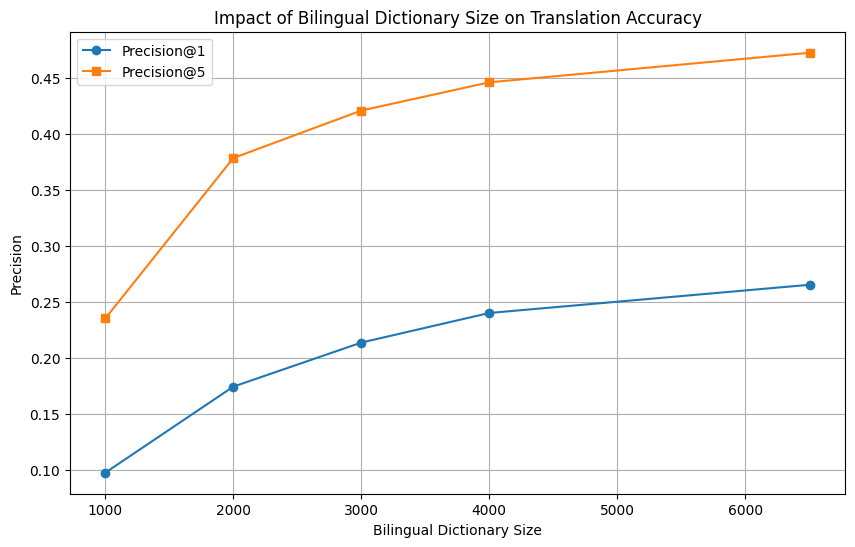


Sample translations:
globe -> ['देश', 'दुनिया', 'देशों', 'कोने', 'दुनियां']
gross -> ['बढ़ोत्तरी', 'पापकर्म', 'व्यहवार', 'गाढ़ी', 'जीडीपी']
gradually -> ['धीरे', 'तेजी', 'बढ़ने', 'बाद', 'बढऩे']
managing -> ['प्रबंधन', 'संभालना', 'काम', 'संभालने', 'जिम्मेदारियां']
experiment -> ['परीक्षण', 'अनुमापन', 'अध्ययन', 'आजमाया', 'प्रयोगशाला']

Mapping matrix saved to mapping_matrix.npy


In [16]:
# Main
def main():
    #Converting loaded models to dictionaries
    print("Processin")
    en_dict = {word: en_model[word] for word in en_top_words}
    hi_dict = {word: hi_model[word] for word in hi_top_words}

    #Download and process MUSE bilingual dictionary
    en_hi_path, hi_en_path = download_muse_dictionary()

    #Loading dictionaries
    print("Loading bilingual dictionary")
    word_pairs = load_dictionary(en_hi_path, en_dict, hi_dict)
    print(f"Found {len(word_pairs)} valid word pairs")

    #Split into train and test sets (80/20 split)
    train_size = int(0.8 * len(word_pairs))
    train_dict = word_pairs[:train_size]
    test_dict = word_pairs[train_size:]
    print(f"Train dictionary size: {len(train_dict)}")
    print(f"Test dictionary size: {len(test_dict)}")

    #Learn Procrustes alignment
    mapping_matrix = learn_procrustes_alignment(en_dict, hi_dict, train_dict)

    #Evaluate translation accuracy
    p_at_1, _ = compute_precision_at_k(en_dict, hi_dict, test_dict, mapping_matrix, k=1)
    p_at_5, translations = compute_precision_at_k(en_dict, hi_dict, test_dict, mapping_matrix, k=5)

    #Conduct ablation study
    dict_sizes = [1000, 2000, 3000, 4000, len(train_dict)]
    ablation_results = ablation_study(en_dict, hi_dict, train_dict, test_dict, dict_sizes)

    #Analyze cosine similarities
    similarities = analyze_cosine_similarities(en_dict, hi_dict, test_dict[:100], mapping_matrix)  #Analyze first 100 pairs


    sorted_sims = sorted(similarities, key=lambda x: x[2], reverse=True)#Sort similarities and print top and bottom examples

    print("\nTop 10 most similar word pairs after alignment:")
    for src, tgt, sim in sorted_sims[:10]:
        print(f"{src} - {tgt}: {sim:.4f}")

    print("\nBottom 10 least similar word pairs after alignment:")
    for src, tgt, sim in sorted_sims[-10:]:
        print(f"{src} - {tgt}: {sim:.4f}")

    #Visualizing ablation results
    plot_ablation_results(ablation_results, dict_sizes)

    #Printing some sample translations
    print("\nSample translations:")
    sample_words = list(translations.keys())[:5]
    for word in sample_words:
        print(f"{word} -> {translations[word]}")


    np.save('mapping_matrix.npy', mapping_matrix) #Saving results
    print("\nMapping matrix saved to mapping_matrix.npy")



    # #Extras--Compare supervised and unsupervised methods
    # print("\n### Extra Credit: Comparing Supervised and Unsupervised Methods ###")
    # comparison_results = compare_methods(en_dict, hi_dict, word_pairs)
    # print("Results:")
    # for method, scores in comparison_results.items():
    #     print(f"{method}: P@1 = {scores['p@1']:.4f}, P@5 = {scores['p@5']:.4f}")

if __name__ == "__main__":
    main()